# Анализ успешности игр

## Описание проекта 
Из открытых данных предоставленны данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Предоставлены данные до 2016 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации *ESRB* (англ. *Entertainment Software Rating Board*). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Содержание проекта
1. <a href='#step-1'>Открытие данных и изучение общей информации.</a>
2. <a href='#step-2'>Предобработка данных.</a>
3. <a href='#step-3'>Исследовательский анализ данных.</a>
4. <a href='#step-4'>Составление портрета пользователя каждого региона.</a>
5. <a href='#step-5'>Проверка гипотез.</a>
6. <a href='#step-6'>Общий вывод.</a>

### <a id='step-1'>Шаг 1. Открытие данных и изучение общей информации.</a>

In [1]:
# Импортируем нужные библиотеки и изучим общую информацию.
import pandas as pd
import matplotlib as plt
import numpy as np
from scipy import stats as st

data = pd.read_csv('/datasets/games.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


#### Вывод
Значительных проблем в данных не наблюдается. Необходимо будет провести провести предобработку данных для последующего анализа. 

### <a id='step-2'>Шаг 2. Предобработка данных.</a>

Предстоит:
- Привести названия столбцов к нижнему регистру.
- Преобразовать данные в столбцах к нужному типу — *'year_of_release'* в int для того, чтобы убрать нули в конце и *'user_score'* во float для работы с числами.
- Обработать пропуски в стобцах с пропущенными значениями, где их не слишком много — *'year_of_release'*, *'name'*, *'genre'*.
- Пропуски в стобцах *'critic_score'*, *'user_score'* и *'rating'* обрабатывать не будем, они присутствуют у старых игр, когда оценки и рейтинги ещё не выставлялись.
- Но в столбце *'user_score'* присутствуют значения 'tbd'. TBD расшифровывается как *to be determined* (*англ.* будет определено). Это значит, что на момент получения данных рейтинг не был определён и, соответственно, значение отсутствует. Мы заменем 'tbd' пустым значением NaN.
- Некоторые рейтинговые категории переименовали в другие, например, 'K-A' (Kids-Adults) переименовали в 'E' (Everyone). Также, существует рейтинг RP, который скорее является "заглушкой" для невышедших игр, ожидающих присвоения рейтинга, игры с этим рейтингом мы уберём. После, нужно будет заполнить пустые значения для того, чтобы показать, что рейтинг не был выставлен ESRB: игра могла выйти до существования организации или не продаваться в северовмериканском регионе, где и действует рейтинг ESRB.
- И наконец, необходимо будет добавить столбец с суммарными продажами по всем регионам.

In [2]:
# Переведём имена столбцов в нижний регистр.
data.columns = data.columns.str.lower()

# Сбросим пустые значения в столбцах 'year_of_release' и 'name'.
data.dropna(axis='rows', subset=['year_of_release', 'name', 'genre'], inplace=True)

# Уберём хвосты в столбце 'year_of_release'.
data['year_of_release'] = data['year_of_release'].astype('int')

# Заменим значения 'tbd' в 'user_score' на пустые значения и затем, переведём во float.
data['user_score'] = data['user_score'].replace('tbd', 'NaN')
data['user_score'] = data['user_score'].astype('float')

data['rating'] = data['rating'].replace('K-A', 'E')
data = data.query('rating not in "RP"')
data['rating'] = data['rating'].fillna('Не выставлен ESRB')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
name               16443 non-null object
platform           16443 non-null object
year_of_release    16443 non-null int64
genre              16443 non-null object
na_sales           16443 non-null float64
eu_sales           16443 non-null float64
jp_sales           16443 non-null float64
other_sales        16443 non-null float64
critic_score       7982 non-null float64
user_score         7462 non-null float64
rating             16443 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Не выставлен ESRB
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Не выставлен ESRB
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,Не выставлен ESRB
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,Не выставлен ESRB


In [3]:
# Создадим функцию для подсчёта общих продаж.
def count_sum_sales(row):
    """
    Считает общие продажи, складывая значения из стобцов
    'na_sales', 'eu_sales', 'jp_sales' и 'other_sales', 
    и затем возвращает значение.
    """
    na_sales = row['na_sales']
    eu_sales = row['eu_sales']
    jp_sales = row['jp_sales']
    other_sales = row['other_sales']
    
    sum_sales = na_sales + eu_sales + jp_sales + other_sales
    return sum_sales

# Применяем функцию для создания столбца 'total_sales', в котором будут храниться обшие продажи.
data['total_sales'] = data.apply(count_sum_sales, axis=1)
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Не выставлен ESRB,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Не выставлен ESRB,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,Не выставлен ESRB,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,Не выставлен ESRB,28.31


#### Вывод
Предобработка прошла успешно, удалось приготовить данные к последующему анализу.

### <a id='step-3'>Шаг 3. Исследовательский анализ данных.</a>

Посмотрим, сколько игр выпускалось в разные годы.

Text(0, 0.5, 'Количество выпущенных игр')

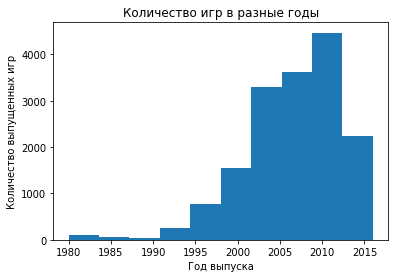

In [4]:
year_of_release_plot = data['year_of_release'].plot(kind='hist', title='Количество игр в разные годы')
year_of_release_plot.set_xlabel('Год выпуска')
year_of_release_plot.set_ylabel('Количество выпущенных игр')

Как можно видеть, до конца 90-ых годов игр выпускалось очень мало, по сравнению с последующими годами, но резкий рост пришёлся на период между 2000 и 2005 годом, а в период между 2010 и 2015 годом количество игр пошло на спад.

Найдём платформы с наибольшими суммарными продажами и построим распределение по годам, чтобы понять, за какой срок появляются новые платформы и исчезают старые. Возьмём топ-11 платформ по продажам.

Платформа с самым большим количеством продаж: PS2


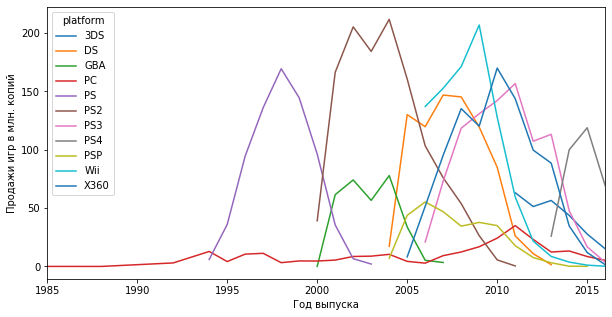

In [5]:
# Создадим сводную таблицу, где будут показаны платформы по продажам в порядке убывания.
top_platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum'
    ).sort_values(by='total_sales', ascending=False).reset_index()

# Создадим срез, показывающий только первые 11 платформ по продажам.
top_11_platforms = top_platform_sales['platform'][:11]
top_platform_name = top_11_platforms[0]
# Создадим срез в данных по топ-11 платформам по продажам и выведем график, показывающий срок жизни этих платформ.
data_by_top_11_platforms = data.query('platform in @top_11_platforms')
top_11_plot = data_by_top_11_platforms.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum'
                                    ).plot(figsize=(10,5))
top_11_plot.set_xlabel('Год выпуска')
top_11_plot.set_ylabel('Продажи игр в млн. копий')

print(f'Платформа с самым большим количеством продаж: {top_platform_name}')

Платформы на графике живут от 7 лет (GBA), до 12 лет (PS2). Старые платформы исчезают один-два года после появления новой платформы от той же компании (к примеру, GB и GBA от Nintendo и PS/PS2 от Sony). Исключением из правила является PC, платформа живёт и по сей день, а её продажи хоть и относительно низки, но стабильны. Лидером же по продажам ща всё время является PS2.

Возьмём данные за актуальныйй период. Это поможет построить прогноз на 2017 год.

Возьмём за актуальный период продажи, начиная с 2013 года — тогда появилось новое поколение консолей: Xbox One (XOne) и PS4.

In [6]:
# Сделаем срез с 2013 года.
actual_data = data.query('year_of_release >= 2013')
actual_data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Не выставлен ESRB,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Не выставлен ESRB,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Не выставлен ESRB,11.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,Не выставлен ESRB,9.18
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58


Text(0, 0.5, 'Продажи игр в млн. копий')

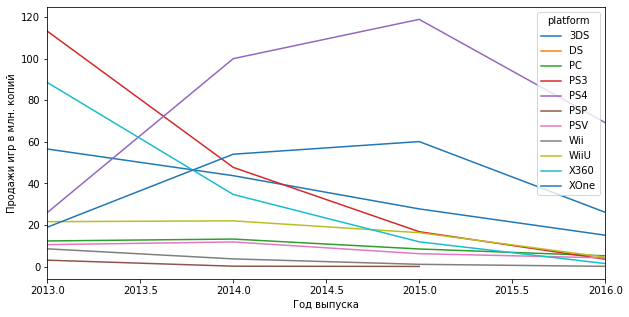

In [7]:
actual_data_plot = actual_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum'
                                    ).plot(figsize=(10,5))
actual_data_plot.set_xlabel('Год выпуска')
actual_data_plot.set_ylabel('Продажи игр в млн. копий')

Среди наиболее актуальных платформ XBox One (XOne) и PS4, появившиеся позже всех (2013 год), а так же 3DS, держащаяся на третьем месте. Они же и обладают наибольшими продажами за 2014-2016 годы, не считая PS3, уже считающейся прошлым поколением, и её продажи в это время начали падать. Также, в список акутальных платформ входит PC со своими стабильными продажами и непрекращающимся жизненным циклом.

Построим график "ящик с усами" 

Text(0, 0.5, 'Продажи игр в млн. копий')

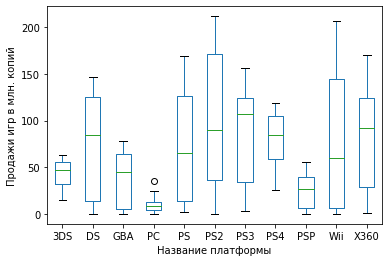

In [8]:
# Игнорируем высвечивающиеся предупреждение.
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

top_11_platforms_boxplot = data_by_top_11_platforms.pivot_table(
    index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(kind='box')
top_11_platforms_boxplot.set_xlabel('Название платформы')
top_11_platforms_boxplot.set_ylabel('Продажи игр в млн. копий')

Как можно заметить, выбросы среди популярных платформ наблюдаются только у PC. Также, несмотря на меньше количество продаж, верхняя и нижняя граница графика по Wii почти не отличается от графика по PS2.

Посмотрим, как на продажи одной популярной платформы влияют отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. В качестве примера возьмём данные по PS2.

Коэффицент корреляции продаж к оценкам критиков: 0.39
Коэффицент корреляции продаж к пользовательским оценкам: 0.18


Text(0, 0.5, 'Оценка пользователей')

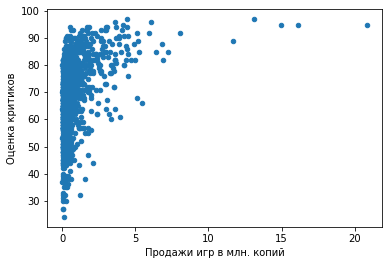

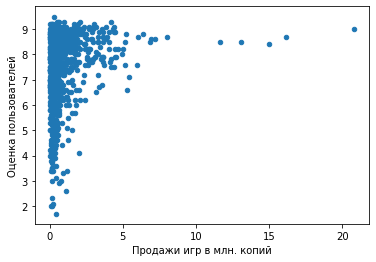

In [9]:
ps2_data = data.query('platform == "PS2"')
print(f"Коэффицент корреляции продаж к оценкам критиков: {ps2_data['total_sales'].corr(ps2_data['critic_score']):.2f}")
print(f"Коэффицент корреляции продаж к пользовательским оценкам: {ps2_data['total_sales'].corr(ps2_data['user_score']):.2f}")
ps2_critic_score_plot = ps2_data.plot(x='total_sales', y='critic_score', kind='scatter')
ps2_critic_score_plot.set_xlabel('Продажи игр в млн. копий')
ps2_critic_score_plot.set_ylabel('Оценка критиков')
ps2_user_score_plot = ps2_data.plot(x='total_sales', y='user_score', kind='scatter')
ps2_user_score_plot.set_xlabel('Продажи игр в млн. копий')
ps2_user_score_plot.set_ylabel('Оценка пользователей')

Как показали диаграммы рассеяния и коэффиценты корреляции, сильной связи между отзывами пользователей и критиков не наблюдается, продажи большинства высокооценённых игр не превышает 5 млн копий, но все игры с продажами 5 млн копий или больше были оценены как минимум выше 6/60 баллов.

Скорее всего, и на других платформах наблюдается похожая ситуация, где по продажам большинство игр находится ниже определённого порога, и крайне малое количество выходит за него, и всем им поставили выше определённой оценки.

Посмотрим на общее распределение игр по жанрам — по количеству созданных игр и по количеству проданных копий.

Text(0, 0.5, 'Продажи игр в млн. копий')

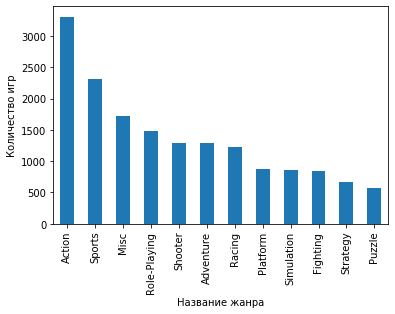

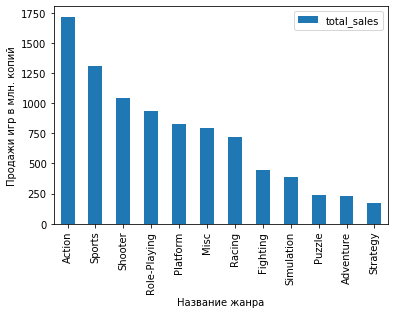

In [10]:
genres = data.groupby('genre')['genre'].count()
top_genre_sales = data.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
games_by_genres_plot = genres.sort_values(ascending=False).plot(kind='bar')
games_by_genres_plot.set_xlabel('Название жанра')
games_by_genres_plot.set_ylabel('Количество игр')
top_genre_sales_plot = top_genre_sales.plot(kind='bar')
top_genre_sales_plot.set_xlabel('Название жанра')
top_genre_sales_plot.set_ylabel('Продажи игр в млн. копий')

#### Вывод

Как можно заметить, среди жанров с высокими продажами выделяются Action и Sports, позиции в обоих графиках совпадают, они находятся на первых двух местах, причём Action заметно преобладает. Наименее популярным жанром является Strategy, по этому жанру было продано меньше всего копий и количество выпущенных игр тоже одно из самых низких. По количеству выпущенных игр на последней строчке находится Puzzle, но при этом количество проданных копий выше, чем у Strategy.

### <a>Шаг 4. Составление портрета пользователя каждого региона.</a>

Определим портрет для пользователя каждого региона (NA, EU, JP, другие):

- <a href='#popular-platforms'>Самые популярные платформы (топ-5)</a>
- <a href='#popular-genres'>Самые популярные жанры (топ-5)</a>
- <a href='#popular-rating'>Влияние рейтинга ESRB на продажи в отдельном регионе</a>

#### <a id='popular-platforms'>Самые популярные платформы (топ-5)</a>

По североамериканскому региону (NA)

Text(0, 0.5, 'Продажи игр в млн. копий')

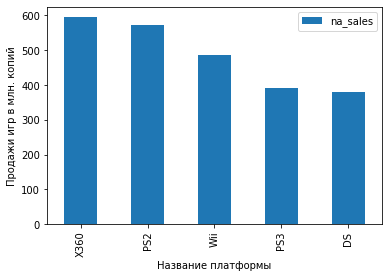

In [11]:
na_top_platform_sales = data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_5_na_platform_sales_plot = na_top_platform_sales[:5].plot(kind='bar')
top_5_na_platform_sales_plot.set_xlabel('Название платформы')
top_5_na_platform_sales_plot.set_ylabel('Продажи игр в млн. копий')

По европейскому региону (EU)

Text(0, 0.5, 'Продажи игр в млн. копий')

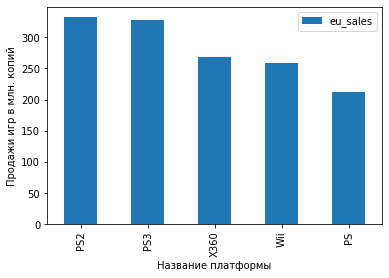

In [12]:
eu_top_platform_sales = data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_5_eu_platform_sales_plot = eu_top_platform_sales[:5].plot(kind='bar')
top_5_eu_platform_sales_plot.set_xlabel('Название платформы')
top_5_eu_platform_sales_plot.set_ylabel('Продажи игр в млн. копий')

По японскому региону (JP)

Text(0, 0.5, 'Продажи игр в млн. копий')

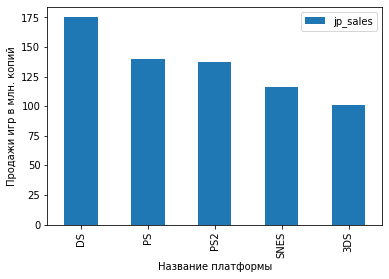

In [13]:
jp_top_platform_sales = data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_5_jp_platform_sales_plot = jp_top_platform_sales[:5].plot(kind='bar')
top_5_jp_platform_sales_plot.set_xlabel('Название платформы')
top_5_jp_platform_sales_plot.set_ylabel('Продажи игр в млн. копий')

По остальным регионам (Other)

Text(0, 0.5, 'Продажи игр в млн. копий')

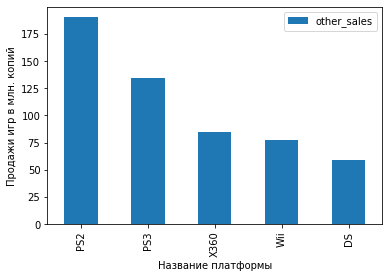

In [14]:
other_top_platform_sales = data.pivot_table(index='platform', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False)
top_5_other_platform_sales_plot = other_top_platform_sales[:5].plot(kind='bar')
top_5_other_platform_sales_plot.set_xlabel('Название платформы')
top_5_other_platform_sales_plot.set_ylabel('Продажи игр в млн. копий')

Сразу бросается в глаза то, что на японском рынке в топ-5 не входит Xbox 360, в отличие от других регионов. Кажется, там предпочитают платформы, выпущенные "домашними" компаниями. В североамериканском регионе же лидирует тот же Xbox 360, выпущенный американской Microsoft. Среди общего можно заметить, что во всех списках среди популярных платформ присутствует PS2, так же являющейся платформой с наибольшим количеством проданных копий за всё время.

#### <a id='popular-genres'>Самые популярные жанры (топ-5)</a>

Text(0, 0.5, 'Продажи игр в млн копий')

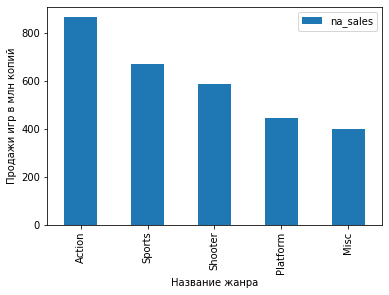

In [15]:
na_top_genres_sales = data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
top_5_na_genres_sales_plot = na_top_genres_sales[:5].plot(kind='bar')
top_5_na_genres_sales_plot.set_xlabel('Название жанра')
top_5_na_genres_sales_plot.set_ylabel('Продажи игр в млн копий')

Text(0, 0.5, 'Продажи игр в млн копий')

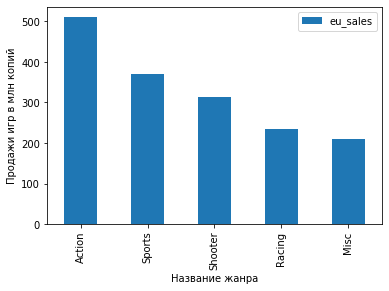

In [16]:
eu_top_genres_sales = data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_5_eu_genres_sales_plot = eu_top_genres_sales[:5].plot(kind='bar')
top_5_eu_genres_sales_plot.set_xlabel('Название жанра')
top_5_eu_genres_sales_plot.set_ylabel('Продажи игр в млн копий')

Text(0, 0.5, 'Продажи игр в млн копий')

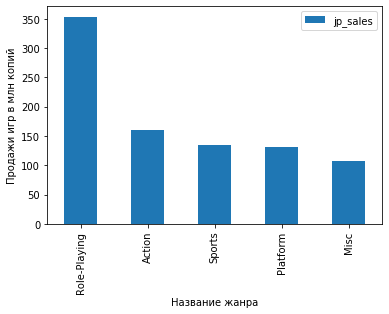

In [17]:
jp_top_genres_sales = data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_5_jp_genres_sales_plot = jp_top_genres_sales[:5].plot(kind='bar')
top_5_jp_genres_sales_plot.set_xlabel('Название жанра')
top_5_jp_genres_sales_plot.set_ylabel('Продажи игр в млн копий')

Text(0, 0.5, 'Продажи игр в млн копий')

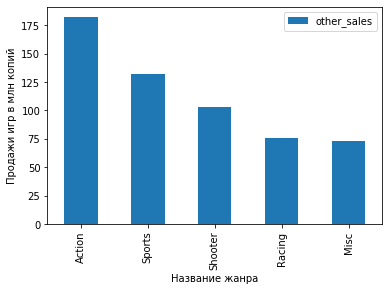

In [18]:
other_top_genres_sales = data.pivot_table(index='genre', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False)
top_5_other_genres_sales_plot = other_top_genres_sales[:5].plot(kind='bar')
top_5_other_genres_sales_plot.set_xlabel('Название жанра')
top_5_other_genres_sales_plot.set_ylabel('Продажи игр в млн копий')

По графикам, японский регион сразу же выделяется тем, что в нём жанр Role-Playing является гораздо более популярным, чем в других регионах, и в пятёрку популярных жанров не входит Shooter.

У североамериканского, европейского и остальных регионов же первые три места и последнее занимают одни и те же жанры: Action, Sports, Shooter и Misc. Но в североамериканском регионе предпочитают жанр Platform жанру Racing в остальных двух регионах.

#### <a id='popular-rating'>Влияние рейтинга ESRB на продажи в отдельных регионах</a>
Справка по рейтингу:
- «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и старше и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше; такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера.
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови.
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории. 
- «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением.

Text(0, 0.5, 'Продажи игр в млн копий')

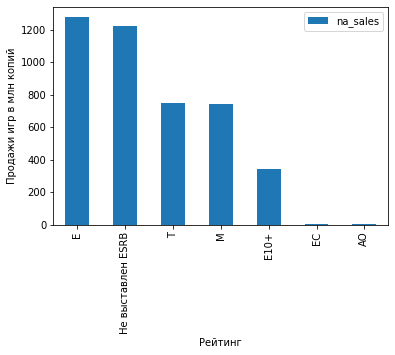

In [19]:
na_top_rating_sales = data.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
na_top_rating_sales_plot = na_top_rating_sales.plot(kind='bar')
na_top_rating_sales_plot.set_xlabel('Рейтинг')
na_top_rating_sales_plot.set_ylabel('Продажи игр в млн копий')

Text(0, 0.5, 'Продажи игр в млн копий')

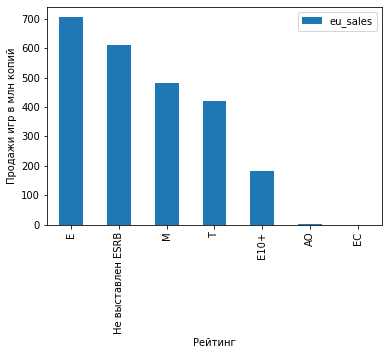

In [20]:
eu_top_rating_sales = data.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
eu_top_rating_sales_plot = eu_top_rating_sales.plot(kind='bar')
eu_top_rating_sales_plot.set_xlabel('Рейтинг')
eu_top_rating_sales_plot.set_ylabel('Продажи игр в млн копий')

Text(0, 0.5, 'Продажи игр в млн копий')

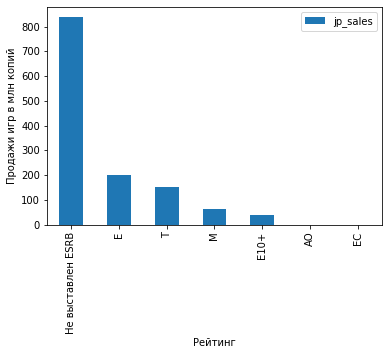

In [21]:
jp_top_rating_sales = data.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
jp_top_rating_sales_plot = jp_top_rating_sales.plot(kind='bar')
jp_top_rating_sales_plot.set_xlabel('Рейтинг')
jp_top_rating_sales_plot.set_ylabel('Продажи игр в млн копий')

Text(0, 0.5, 'Продажи игр в млн копий')

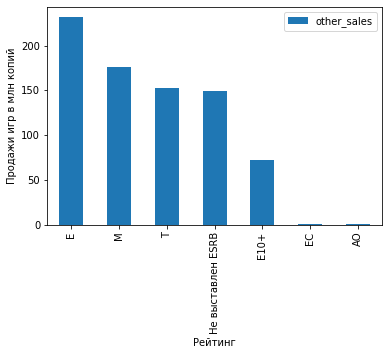

In [22]:
other_top_rating_sales = data.pivot_table(index='rating', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False)
other_top_rating_sales_plot = other_top_rating_sales.plot(kind='bar')
other_top_rating_sales_plot.set_xlabel('Рейтинг')
other_top_rating_sales_plot.set_ylabel('Продажи игр в млн копий')

Неожиданно высокой высокой долей обладают игры без рейтинга ESRB, особенно в японском регионе. Скорее всего речь идёт либо о старых играх, которые вышли до создания ESRB, либо об играх, не продававшихся в североамериканском регионе, где и действует ESRB. 

В тройку самых популярных рейтингов вошли E, M и T. Причём E везде на первом месте, как самый распространённый рейтинг. В североамериканском регионе M и T распределены по продажам примерно поровну, в европейском и остальных регионах продажи игр с рейтингом M превосходят игры с рейтингом T. На четвёртом месте везде рейтинг E10+, и последние места занимают игры с рейтингом EC и AO, продажи которых невероятно малы по сравнению с остальными рейтингами из-за аудитории (EC для детей от трёх лет и AO только взрослых старше 18+)

#### Вывод
Для начала, портрет среднего пользователя японского региона гораздо сильнее отличается от других регионов. В топ-5 платформ не присутствует Xbox360 и присутствует старичок SNES, а среди жанров с большим отрывом преобладает Role-Playing, в отличие от остальных регионов, где на первом месте Action. 

По распределением жанров остальные регионы не сильно отличаются, кроме североамериканского, где на четвёртом месте находится жанр Platform, в отличие от европейского и других регионов с Racing на четвёртом месте. 

И на всех графиках одной из самой популярных платформ является PS2, которая так же имеет самое количество проданных копий игр для неё.

Также, не стоит всегда полагаться на рейтинг ESRB, у некоторых игр его может и не быть.

### <a id='step-5'>Шаг 5. Проверка гипотез.</a>

Необходимо выяснить, одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC. Найдём средние пользовательские рейтинги для этих платформ и затем проверим гипотезу о том, что они одинаковые.

In [23]:
# Делаем выборку для пользовательских оценок двух платформ.
pc_user_score = data.query('platform == "PC" and user_score.notna()')['user_score']
xone_user_score = data.query('platform == "XOne" and user_score.notna()')['user_score']

# Найдём среднюю пользовательскую оценку.
mean_pc_user_score = pc_user_score.mean()
mean_xone_user_score = xone_user_score.mean()

print(f'Средняя пользовательская оценка для PC: {mean_pc_user_score:.2f}')
print(f'Средняя пользовательская оценка для Xbox One: {mean_xone_user_score:.2f}')

Средняя пользовательская оценка для PC: 7.07
Средняя пользовательская оценка для Xbox One: 6.52


Средний рейтинг различается. Посмотрим его различие в процентах.

In [24]:
print(f'Рейтинг различается на {mean_pc_user_score / mean_xone_user_score - 1:.2%}')

Рейтинг различается на 8.36%


Определим, схожи ли дисперсии выборок и соответственно, схожи ли они по параметрам.

In [25]:
# Ищем дисперсию.
pc_user_score_var = np.var(pc_user_score)
xone_user_score_var = np.var(xone_user_score)

print(f'Дисперсия для PC: {pc_user_score_var:.2f}')
print(f'Дисперсия для Xbox One: {xone_user_score_var:.2f}')

Дисперсия для PC: 2.35
Дисперсия для Xbox One: 1.90


Проверим нашу гипотезу. За нулевую гипотезу возьмём утверждение, что рейтинги платформ равны. В качестве же альтернативной гипотезы возьмём обратное утверждение: что рейтинги платформ не равны. Посмотрим, не противоречит ли результат гипотезе.

In [26]:
# Выставляем пороговое значение alpha. Отвергаем гипотезу, если p-значение меньше alpha.
alpha = .05

# Сопоставим средние генеральных совокупностей. Так как дисперсии 
# различаются достаточно, для метода выставим equal_var равным False.
results = st.ttest_ind(pc_user_score, xone_user_score, equal_var=False)

# Вычисляем p-значение.
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.50331430311674e-06
Отвергаем нулевую гипотезу


Нулевая гипотеза (рейтинг платформ равен) была отвергнута.

Теперь необходимо проверить гипотезу о том, что средние пользовательские оценки жанров Action и Sports разные. Найдём средние пользовательские оценки для этих жанров и затем проверим гипотезу о том, что они разные.

In [27]:
# Делаем выборку для двух жанров.
action_user_score = data.query('genre == "Action" and user_score.notna()')['user_score']
sports_user_score = data.query('genre == "Sports" and user_score.notna()')['user_score']

# Найдём среднюю пользовательскую оценку.
mean_action_user_score = action_user_score.mean()
mean_sports_user_score = sports_user_score.mean()
print(f'Средняя пользовательская оценка для Action: {mean_action_user_score:.2f}')
print(f'Средняя пользовательская оценка для Sports: {mean_sports_user_score:.2f}')

Средняя пользовательская оценка для Action: 7.06
Средняя пользовательская оценка для Sports: 6.95


Различия в среднем рейтинге достаточно малы.

Определим, схожи ли дисперсии выборок и соответственно, схожи ли они по параметрам.

In [28]:
# Ищем дисперсию.
action_user_score_var = np.var(action_user_score)
sports_user_score_var = np.var(sports_user_score)

print(f'Дисперсия для Action: {action_user_score_var:.2f}')
print(f'Дисперсия для Sports: {sports_user_score_var:.2f}')

Дисперсия для Action: 2.03
Дисперсия для Sports: 2.62


Проверим нашу гипотезу. За нулевую гипотезу возьмём утверждение, что рейтинги жанров равны. В качестве же альтернативной гипотезы возьмём обратное утверждение: что рейтинги жанров не равны. Посмотрим, не противоречит ли результат гипотезе.

In [29]:
# Сопоставим средние генеральных совокупностей. Так как дисперсии 
# различаются достаточно, для метода выставим equal_var равным False.
results = st.ttest_ind(action_user_score, sports_user_score, equal_var=False)

# Вычисляем p-значение.
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.07370217419278534
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза (рейтинги жанров равны) не была опровергнута.

#### Вывод
В случае со средним рейтингом двух платформ (Xbox One и PC) можно утверждать, что среднее между двумя генеральными совокупностями различается, и вероятность этого достаточно высока. Но в случае со средним рейтингом двух жанров (Action и Sports), нулевую гипотезу отвергнуть не получилось, средний рейтинг жанров не отличается, а если и отличается, то незначительно.

### <a id='step-6'>Шаг 6. Общий вывод.</a> 

Было замечено, что самыми продаваемыми играми в среднем были игры в жанре Action и Sports, с рейтингом E (для всех). Из платформ же стоит обратить внимание на PS4 и Xbox One, как на самые новые из списка и с ещё не начавшим прекращаться жизненным циклом, на 3DS, находящейся на 3-ем месте по продажам за последние два года и на PC, как на платформу с не такими большими, но стабильными продажами, и которая точно не уйдёт с рынка.